<h1>Оценка и анализ моделей</h1>

Первоначально оценим  метрики моделей, чтобы понять какую из них лучше всего брать для обучения

Из моделей рассматриваются:
- yolo v8 nano
- yolo v8 small
- yolo v11 nano

>Блокнот используется только для оценки, все рассчеты и вспомогательные функции описаны  .py файлах

In [2]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
#Лямбда функция для помощи датафрейму
data_metrics = lambda model_metrics:{
    'mAP50': float(model_metrics.box.map50),
    'mAP50-95': float(model_metrics.box.map),
    'mAP75': float(model_metrics.box.map75),
    'Precision': float(model_metrics.box.mp),
    'Recall': float(model_metrics.box.mr),
}


In [19]:
def plot_metrics(data):
    # Создаем DataFrame
    df = pd.DataFrame([data])

    # Создаем один график с несколькими гистограммами
    fig, ax = plt.subplots(figsize=(6, 4))

    # Преобразуем данные для построения
    metrics = list(data.keys())
    values = list(data.values())

    # Создаем столбчатую диаграмму (похожа на гистограмму для одного значения)
    bars = ax.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet'], alpha=0.7)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    # Настройки графика
    ax.set_ylabel('Значения метрик')
    ax.set_xlabel('Метрики')
    ax.set_title('Финальные метрики модели')
    ax.set_ylim(0, 1.0)  # Так как все метрики в диапазоне 0-1
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Улучшаем расположение
    plt.tight_layout()
    plt.show()

>Для теста было решено взять 100 фреймов из виде о разметить на них людей, чтобы можно было оценить модель на том же видео что и распознаются люди

In [31]:
model8n = YOLO("yolov8n.pt")
metrics8n = model8n.val(data="videos/test_dataset/data.yaml",
                    split="test")

model8s = YOLO("yolov8s.pt")
metrics8s = model8s.val(data="videos/test_dataset/data.yaml",
                    split="test")

model11n = YOLO("yolo11n.pt")
metrics11n = model11n.val(data="videos/test_dataset/data.yaml",
                    split="test")


Ultralytics 8.3.220 🚀 Python-3.11.9 torch-2.9.0 CPU (Apple M3)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 390.5±27.4 MB/s, size: 88.5 KB)
val: Scanning /Users/dr.sex/Documents/PycharmProjects/PyCharmMiscProject/videos/test_dataset/test/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 406.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 0.6it/s 11.5s2.1s
                   all        100       1547      0.698      0.551      0.629      0.227
                person        100       1547      0.698      0.551      0.629      0.227
Speed: 0.7ms preprocess, 106.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /Users/dr.sex/Documents/PycharmProjects/PyCharmMiscProject/runs/detect/val8
Ultralytics 8.3.220 🚀 Python-3.11.9 torch-2.9.0 CPU (Apple M3)
YOLOv8s summary (fused): 72 lay

In [32]:
data8n = data_metrics(metrics8n)
data8s = data_metrics(metrics8s)
data11n = data_metrics(metrics11n)

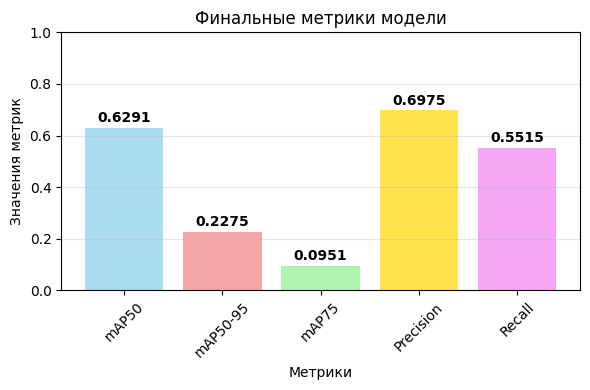

In [33]:
plot_metrics(data8n)

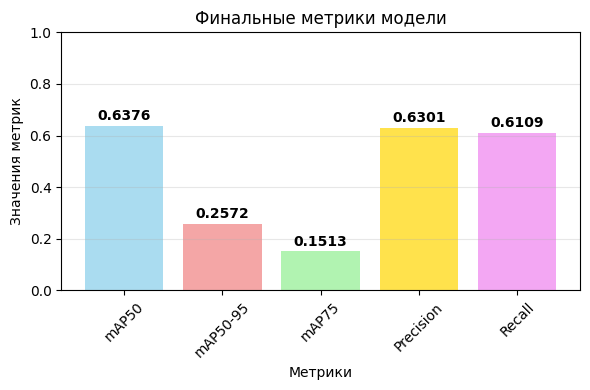

In [34]:
plot_metrics(data8s)

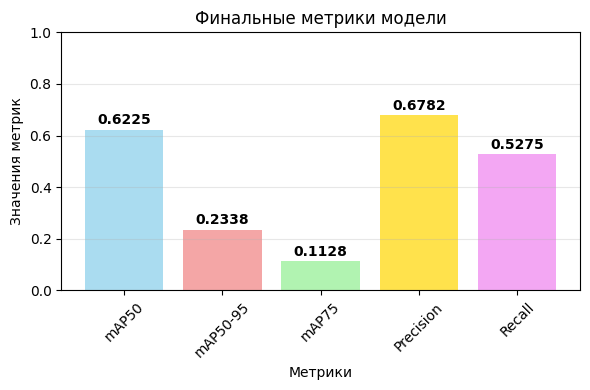

In [35]:
plot_metrics(data11n)

Как видно из метрик, лучша необученная модель - v8 small. Для лучших резутьтаов предлагаю дообучить ее на этом датасете

https://www.kaggle.com/datasets/luiscrmartins/surveillance-images-for-person-detection/data


In [52]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("luiscrmartins/surveillance-images-for-person-detection")


path += '/person-3'
print("Path to dataset files:", path)

Path to dataset files: /Users/dr.sex/.cache/kagglehub/datasets/luiscrmartins/surveillance-images-for-person-detection/versions/1/person-3


>Для удобства в ручную объеденим датасет, чтобы были все части выборки

In [55]:
# Загрузка модели
model = YOLO("yolov8s.pt")  # или "yolov8s.pt", "yolo11n.pt"


# Базовая тренировка
results = model.train(
    data=f"videos/test_dataset/data.yaml",  # путь к data.yaml
    epochs=25,                 # количество эпох
    imgsz=640,                 # размер изображения
    batch=16,                  # размер батча
    device='cpu',              # 'cpu' или 'cuda' если есть GPU
    workers=2,                 # количество воркеров
    save=True,                 # сохранять чекпоинты
    project='runs/detect',     # папка для результатов
    name='yolov8n_train',
)

print("Тренировка завершена!")

New https://pypi.org/project/ultralytics/8.3.221 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.220 🚀 Python-3.11.9 torch-2.9.0 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=videos/test_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_train8, nbs=64, nms=False, opset=None, optimize=

KeyboardInterrupt: 

Оценим улучшение точности теперь уже обученной модели